<a href="https://colab.research.google.com/github/SebasGarcia08/analytics-fund-II-final-workshop-2021-II/blob/master/statement_analytics_fundamentals_II_final_workshop_2021_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src ="https://www.icesi.edu.co/launiversidad/images/La_universidad/logosimbolos/logo_Icesi_PNG.png"/>


<center>
<h1>Final workshop</h1>


**Javier Díaz Cely**

**Universidad ICESI**

**Fundamentos de analítica II**

**Maestría en Ciencia de Datos**

**Santiago de Cali, Valle del Cauca, Colombia**

**2021-02**


</center>

# Introduction 📔

The agricultural sector is one of the sectors that is most benefited from climate forecasts. In particular, the sub-seasonal scale provides information that could help short-term planning of agricultural activities and efficient management of water resources.

There is currently a great boom to implement and improve agroclimatic services in countries that present high vulnerability and little adaptation, since the models that currently provide information on a sub-seasonal scale do not satisfy the needs of the agricultural sector, because they sometimes present problems as very coarse resolution or biases with respect to local climatic conditions.

During the last few years, different studies have shown that there is a wide field of application of artificial intelligence in the modeling of climatic variables. In particular, different authors have proposed AI models for the calibration of precipitation forecasts produced by general circulation models.

# Statement 🌧

You have been hired to train a model responsible for the calibration of sub-seasonal precipitation forecasts in the Colombian rice sector. The target variables is the accumulated precipitation of 1 week occured in each of 4 Colombian departments (Sucre, Córdoba, Norte de Santander and César) and the features are: the forecast outputs of different variables of the European global circulation model (ECMWF) and other variables derived from satellite information.

# Data Set ℹnformation 

There are two sources from which data were gathered:

* [ECMWF model](https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.perturbed/) that provides a resolution of 165 kilometers and retrospective forecasts of 20 years. This model is initialized twice a week (Monday and Thursday), generating in each of these, forecasts with a horizon of 46 days ahead. The first 7 days of forecast generated by this model in the same week of the period of interest are considered. Furthermore, this models generates different output variables, from which 3 were pre-selected for you:

  * Convective Available Potential Energy (CAPE), is the amount of fuel available to a developing thunderstorm, it describes the instabilily of the atmosphere and provides an approximation of updraft strength within a thunderstorm.

  * Total Colum Water (TCW), provides information about the amount
of water, in its different states (water vapor, liquid water, ice clouds, rain and snow), which is present in a column that extends from the earth's surface to the top of the earth atmosphere.

  * Total Accumulated Precipitation (TCP)

* [Climate Hazards Group InfraRed Precipitation with Station](https://iridl.ldeo.columbia.edu/SOURCES/.UCSB/.CHIRPS/.v2p0/) (CHIRPS) is a 35+ year quasi-global rainfall data set since 1981 that provides a resolution of 5 kilometers. From this source two features were extracted:

  * Precipitation map of the prevoius week. Some pixels are NaN because correspond to precipitation in oceanic locations that are not areas of interest.

The training dataset consists of 1400 weeks, for each week, there are four images of shape (56, 42), each one corresponds to the features described above. Notice that each of the features can be considered as channels of an image of shape (56, 42), therefore, the training dataset can be thought as a 4D - tensor with dimensions (1400, 56, 42, 4) where:

* axis 0 is the number of weeks of the dataset (1400) and **can vary**.

* axis 1 is the height of the image (56)

* axis 2 is the width of the image (42)

* axis 3 is the depth or channels of the tensor and correspond to the number of features described above (4).


# Part 0. Data (0.5 points) 🕵

- There are missing values in some pixels of the CHIRPS channel. What technique can you use in order to deal with them? (0.25)

- Try with different normalization techniques. Over which axis should this normalization be perfomed? (0.25)


In [ ]:
!pip install -U -q PyDrive 
!pip install tqdm

**RECOMMENDED** if you are going to train a deep learning model activate GPU in order to speed up training, you can do so following these steps: 

* Navigate to Edit→Notebook Settings

* Select GPU from the Hardware Accelerator drop-down.

Check tha you have been assigned one with the following command:

In [ ]:
!nvidia-smi

Sat Dec  4 19:43:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import gdal as gdal
from google.colab import (
    drive,
    files
)

import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import (
    display, 
    clear_output, 
    HTML
)
from matplotlib import animation 
from tqdm import tqdm

from typing import Tuple
from pathlib import Path
import os
import random
import pickle as pkl

%matplotlib inline

RANDOM_STATE = 42

gpus = tf.config.list_physical_devices('GPU')
print(f"Using tf version: {tf.__version__}")
print(f"GPUs available: {gpus}")

Using tf version: 2.7.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
def get_seed(text: str) -> int:
  return int(hash("setting random seeds") % 2**32 - 1)  

In [ ]:
# DO NOT REMOVE FOR REPRODUCIBILITY
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
random.seed(get_seed("setting random seeds"))
np.random.seed(get_seed("improves reproducibility"))
tf.random.set_seed(get_seed("by removing stochasticity"))

## Data reading



In [ ]:
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user() 
gauth = GoogleAuth() 
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/file/d/1-2bcrjBiOTbwAtggjOjcmY53vG3v5hOs/view?usp=sharing' # to get the id part of the file 
id = link.split("/")[-2] 
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('data.zip') 

In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: content/drive/MyDrive/analytics-II-final-workshop-data/
  inflating: content/drive/MyDrive/analytics-II-final-workshop-data/x_ecmwf.pkl  
  inflating: content/drive/MyDrive/analytics-II-final-workshop-data/x_chirps.pkl  
  inflating: content/drive/MyDrive/analytics-II-final-workshop-data/y_m.csv  
  inflating: content/drive/MyDrive/analytics-II-final-workshop-data/x_ecmwf_predict.pkl  
  inflating: content/drive/MyDrive/analytics-II-final-workshop-data/chirps_lag_2019.tif  


In [ ]:
data_dir = Path("content/drive/MyDrive/analytics-II-final-workshop-data/")
!ls {data_dir}

chirps_lag_2019.tif  x_chirps.pkl  x_ecmwf.pkl	x_ecmwf_predict.pkl  y_m.csv


### Training set

In [ ]:
# Datos del X-ECMWF, debe tener las 3 variables
with open(data_dir.joinpath('x_ecmwf.pkl'),'rb') as f:
     x_0 = pkl.load(f)
     print(f"x_ecmwf: {x_0.shape}")

# Datos de X-CHIRPS de la semana anterior al pronóstico
with open(data_dir.joinpath('x_chirps.pkl'),'rb') as f:
     x_chirps = pkl.load(f)
     print(f"x_chirps: {x_chirps.shape}")

y_0 = pd.read_csv(data_dir.joinpath('y_m.csv'))
# Datos observados de los 4 sitios de interes
y_train = y_0.drop(y_0.columns[[0]], axis=1).to_numpy()#[:,0:3]

print(f"y_train: {y_train.shape}")

x_ecmwf: (1400, 56, 42, 3)
x_chirps: (1400, 56, 42)
y_train: (1400, 4)


In [ ]:
FEATURES_SHAPE = [56, 42, 1]

cape = x_0[:,:,:,0]
tcw  = x_0[:,:,:,1]
tp   = x_0[:,:,:,2]

features = [cape, tcw, tp, x_chirps]

for i in range(len(features)):
  shape = [features[i].shape[0]] + FEATURES_SHAPE
  features[i] = np.reshape(features[i], shape)

X_train = np.concatenate(features, axis=-1)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (1400, 56, 42, 4)
y_train shape: (1400, 4)


## Test features

In [ ]:
with open(data_dir.joinpath('x_ecmwf_predict.pkl'),'rb') as f:
     x_0_test = pkl.load(f)
     print(f"x_0_test: {x_0_test.shape}")

X_test_chirps = gdal.Open(str(data_dir.joinpath('chirps_lag_2019.tif')))
X_test_chirps = X_test_chirps.ReadAsArray() 
print(f"X_test_chirps shape:{X_test_chirps.shape}")

x_0_test: (70, 56, 42, 3)
X_test_chirps shape:(70, 56, 42)


In [ ]:
cape_test = x_0_test[:,:,:,0]
tcw_test  = x_0_test[:,:,:,1]
tp_test   = x_0_test[:,:,:,2]

test_features = [cape_test, tcw_test, tp_test, X_test_chirps]

for i in range(len(test_features)):
  shape = [test_features[i].shape[0]] + FEATURES_SHAPE
  test_features[i] = np.reshape(test_features[i], shape)

X_test = np.concatenate(test_features, axis=-1)
print(f"X_test shape: {X_test.shape}")

X_test shape: (70, 56, 42, 4)


## Visualization

In [ ]:
from typing import NamedTuple

class Datapoint(NamedTuple):
  cape: np.ndarray 
  tcw: np.ndarray
  tp: np.ndarray
  x_chirps: np.ndarray
  accumulated_prec: np.ndarray


In [ ]:
X, y = (X_train, y_train)
nrows, ncols = 1, X.shape[-1]
height, width = X.shape[-3], X.shape[-2]
names = ['CAPE', 'TCW', 'TP', 'CHIRPS (diff last 4 weeks)']

fig, axes = plt.subplots(nrows, len(names), figsize=(4*ncols, 5) )
frames = []
a,b = -1, 1

for i in range(len(axes)):
  axes[i].set_title(names[i])
  init_img = np.random.rand(height, width)
  ax = axes[i].imshow(init_img, animated=True, vmin=a, vmax=b, cmap='jet', aspect='auto')
  frames.append(ax)


def data_gen(
    start_week: int = 0, 
    dataset: Tuple[np.ndarray, np.ndarray] = (X, y),
    num_weeks: int = 4*12
    ) -> Tuple[int, Datapoint]:
    X, y = dataset
    week = start_week 
    for week in tqdm(range(start_week, num_weeks)):
        week += 1
        n_channels = X.shape[-1]
        outs = [None] * n_channels
        for j in range(n_channels - 1):
          outs[j] = X[week,:,:,j]
        
        if week > 4:        
          mean_4weeks_before = np.nan_to_num(X[-4:-1:,:,:,-1], 0).mean(0)
          outs[-1] = np.nan_to_num(X[week,:,:,-1], 0) - mean_4weeks_before
        else:
          outs[-1] = X[week,:,:,-1]
        outs.append(y[week])
        yield week, outs

def normalize(x,a=0,b=1):
  return ( b - a)*(x - x.min(0)) / (x.max(0) - x.min(0)) + a

def run(data: Datapoint):
    week, (*features, accumulated_prec) = data
    fig.suptitle(f"Week: {week}")
    for i in range(len(features)):
      x = normalize(features[i], a=a, b=b)
      frames[i].set_array(x)
    return frames

ani = animation.FuncAnimation(fig, run, data_gen, blit=True, repeat=False)
plt.show()
clear_output()

In [ ]:
HTML(ani.to_html5_video())

100%|██████████| 48/48 [01:26<00:00,  1.81s/it]


## Preparation

Replace -np.inf for nans

In [ ]:
# Add nans
minus_inf = -3.39999995e+38
X_train[:,:,:,-1][X_train[:,:,:,-1]<=minus_inf] = np.nan
X_test[:,:,:,-1][X_test[:,:,:,-1] <= minus_inf] = np.nan

In [ ]:
X_train.reshape(X_train.shape[0], -1).shape # (1400, 56 * 42 * 4)

(1400, 9408)

In [ ]:
new_feature_list = []
x_train_chirps = np.nan_to_num(X_train[:,:,:,-2], 0) # (1400, 56, 42)
print(f"x_train_chirps = {x_train_chirps.shape}")

for week in tqdm(range(0, X_train.shape[0])):
  if week > 4:
    chirps_three_weeks_back = x_train_chirps[-(week+4): -week,:,:] # (3, 56, 42) 
    chirps_three_weeks_back_avg = chirps_three_weeks_back.max(axis=0) # (56, 42)
    new_feature = x_train_chirps[week, :, :] - chirps_three_weeks_back_avg
  else:
    new_feature = x_train_chirps[week, :, :]
  new_feature_list.append(new_feature)

new_feature_chirps = np.array(new_feature_list)

x_train_chirps = (1400, 56, 42)


100%|██████████| 1400/1400 [00:01<00:00, 819.11it/s]


In [ ]:
#plt.figure(fi)
#plt.imshow(new_feature)
#X_train.shape 
#np.concatenate([X_train, new_feature_list[0]], axis=-1)
new_feature_list[0].shape

(1400, 56, 42)

In [ ]:
i = 6
X_train[i-4].shape
# (train_size, 56, 42, 8)

(56, 42, 4)

# Part 1. Shallow models (2.5 points) ☝

Apply SHALLOW models (opposed to deep) to develop predictive models for forecasting the cummulative precipitation of the next weeek:

- Establish variables from historical data. For instance, you can set data such as the average value of each pixel for each feature of the last 2 weeks, 4 weeks, etc., (0.5 points)
  
- Apply feature selection techniques such as PCA and Lasso. (0.5 points) 

- Try SVM, Lasso and Ridge regression models (1 point)

- Try traditional artificial neural network models (0.5 points)

Be aware that you must follow a correct evaluation protocol in order to avoid data leakage from the test sets on the normalization and feature selection processes. Mistakes will be punished (-0.5 points)



In [ ]:
# # YOUR CODE STARTS HERE


# Part 2. Convolutional models (2 points + 1 **BONUS** point) ✌

Consider the data as a multivariate time series and 2-D convolutional neural networks (ConvNets) to predict the accumulated precipitation of the next week:

- Use 2-D convolutional filters and pooling layers. Test different architectures in terms of kernel sizes (for convolutional layers) pooling sizes(for pooling layers) and number of neurons (for dense layers). For example, the input shape of the first Conv2D layer should be (56, 42, 4) (1.5 point)

- Apply and evaluate the impacts of using dropout layers and Ridge/Lasso (also known as L1/L2) regularization techniques with different hyper-parameter values to probe. (0.5)

- **(BONUS)** Take into account observations of previous weeks and establish a  window prediction. The features must then be transformed into a 4D tensor of shape **(window_size, height, width, channels)** in order to predict the next week's accumulated precipitation, plus, adding the batch dimension it would be **(batch_size, window_size, height, width, channels)**. You could take a look at the [TensorFlow Conv3D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv3D) implementation for this (1 point)


As with the shallow models, it is important to establish a well designed evaluation protocol that allows for the comparison of the different architectures.

In [ ]:
def data_generator(X: np.ndarray, y: np.ndarray, window_size: int = 3):
  index = 0
  while True:
    end = index + window_size
    if end > X.shape[0]:
      break
    print(index, end)
    ith_X_week = X[i:end, :, :, :]
    ith_y_week = y[i:end]
    index += 1
    yield ith_X_week, ith_y_week

train_generator = data_generator(X_train, y_train)
train_generator = data_generator(X_val, y_val)
X, y = next(iter(generator))
print(X.shape)
print(y)

0 3
(0, 56, 42, 4)
[]


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(tf.data.AUTOTUNE).batch(32)
train_ds

<BatchDataset shapes: ((None, 56, 42, 4), (None, 4)), types: (tf.float64, tf.float64)>

In [ ]:
Feature test: (70, 56, 42, 4) -> process_data -> (70, n_features)
(None, n_features)


In [ ]:
X, y = next(iter(train_ds))
print(X.shape)
print(y.shape)

(32, 56, 42, 4)
(32, 4)


In [ ]:
y_train

array([[7.40378872e+01, 5.45585103e+01, 1.06812431e+02, 1.39099555e+02],
       [1.85344024e+01, 6.92808312e+00, 3.11784475e+01, 1.90420719e+01],
       [8.20642899e+00, 4.69110616e+00, 1.38388765e+01, 1.29401188e+01],
       ...,
       [8.41635615e+01, 8.03115083e+01, 7.51727310e+01, 8.60089941e+01],
       [1.78929874e+01, 2.28374415e+00, 3.75919947e+01, 4.69030390e+01],
       [2.35145621e-02, 3.43042585e-01, 5.46754423e-01, 5.50115723e-01]])

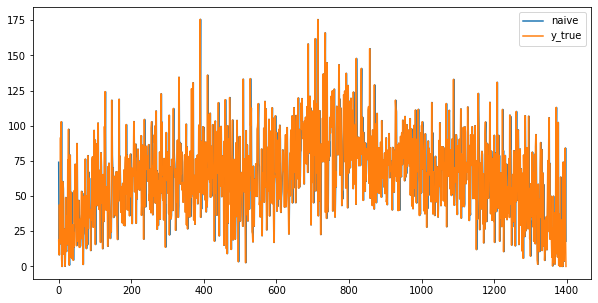

In [ ]:
def r_2(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.divide(residual, total))
  return r2

y_hat_naive = y_train[:-1, :]
y_true_naive = y_train[1:, :]

plt.figure(figsize=(10,5))
plt.plot(np.arange(len(y_hat_naive)), y_hat_naive[:,0], label='naive')
plt.plot(np.arange(len(y_true_naive)), y_true_naive[:,0], label='y_true')
plt.legend()
plt.show()

In [ ]:
from random import Random
val_rate = 0.2
val_size = int(X_train.shape[0] * val_rate)

X_val, y_val = X_train[-val_size:, :, :, :], y_train[-val_size:, :]
train_idxs = np.arange(X_train.shape[0] - X_val.shape[0])
# Random(RANDOM_STATE).shuffle(train_idxs)
X_train_split, y_train_split = X_train[train_idxs], y_train[train_idxs]
print(f"Val X: {X_val.shape}, y: {y_val.shape}")
print(f"Train X: {X_train_split.shape}, y: {y_train_split.shape}")

Val X: (280, 56, 42, 4), y: (280, 4)
Train X: (1120, 56, 42, 4), y: (1120, 4)


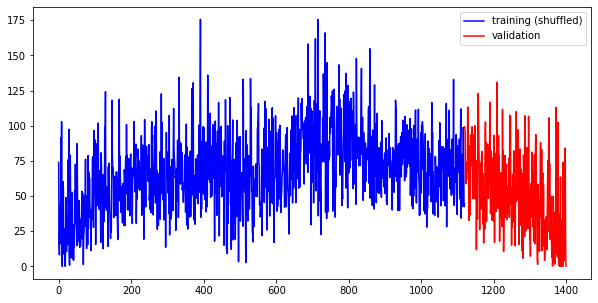

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(
    np.arange(len(y_train_split)), 
    y_train_split[:, 0], 
    color='blue',
    label='training (shuffled)'
)

plt.plot(
    np.arange(len(y_train_split), len(y_train_split) + len(y_val)), 
    y_val[:, 0], color='red', label='validation'
)
plt.legend()
plt.show()

# Part 3: Competition and deliverables (1 **BONUS** point) 🏆

## Inputs 🤖

You are given: 

* Both the features and targets of the training set (1400 weeks until 2018) already pre-processed. You should split a part of this dataset to create a validation set and perform hyper-parameter optimization in order to choose the best architecture.

* Only the features of the **test set** (70 weeks until 2019) already preprocesed. You should generate the predictions for this data with the best model you chose in order to be compared with the true target that will be kept unrevealed.

## Submission format and deliverables ✅

You should deliver:

- Code: a jupyter notebook with the code with which you developed your solution.

- {your_name}_submission.csv: a file with the predictions of the model you chose, where:

  - The first row or header of the file contains the four places of interest: "sucre,cordoba,norte_de_santander,cesar"

  -  The 70 subsequent rows contains the prediction of accumulated precipitation for each of the 4 places of interest.

  - Do **NOT** shuffle the test features, such that the i-th + 1 row of your submission corresponds to the prediction for the i-th datapoint in the test set.   

The metric to assess the performance of your model is [RMSE](https://www.statisticshowto.com/probability-and-statistics/regression-analysis/rmse-root-mean-square-error/).

In [ ]:
# # YOUR CODE STARTS HERE

tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(3,3),
    strides=(1,1)
    activity_regularizer=tf.keras.regularizers.L1(l1=0.01)
)